In [12]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shapely
from libpysal import graph
from sklearn import ensemble, metrics, model_selection
import shap

In [ ]:
!pip install shap

# Import and Preprocess Files

In [48]:
combined_gdf = gpd.read_parquet('/data/processed_data/regression_stats')
combined_gdf = combined_gdf.drop('cluster',axis=1)

Run the following if a new statistics file should be generated

In [11]:
# Define the file paths for each GeoDataFrame
files = [
    '/home/lisa/work/people_places_germany/Notebooks/temp_data/%german.parquet',
    '/home/lisa/work/people_places_germany/Notebooks/temp_data/%holidayapt.parquet',
    '/home/lisa/work/people_places_germany/Notebooks/temp_data/%rented.parquet',
    '/home/lisa/work/people_places_germany/Notebooks/temp_data/age.parquet',
    '/home/lisa/work/people_places_germany/Notebooks/temp_data/apartmentno.parquet',
    '/home/lisa/work/people_places_germany/Notebooks/temp_data/buildingyear.parquet',
    '/home/lisa/work/people_places_germany/Notebooks/temp_data/familysize.parquet',
    '/home/lisa/work/people_places_germany/Notebooks/temp_data/floorspace.parquet'
    ]

# Initialize an empty GeoDataFrame for the final combined data
combined_gdf = None

# Iterate over the files, reading only necessary columns and merging
for file in files:
    # Read 'ID', 'geometry', 'STATS', and 'cluster' columns
    gdf = gpd.read_parquet(file)

    columns = gdf.columns
    
    # Generate names for 'STATS' and 'cluster' columns to avoid conflicts
    base_name = file.split('/')[-1].replace('.parquet', '')
    stat_col_name = base_name
    
    # Rename the columns
    gdf.rename(columns={'STATS': stat_col_name, 'STATS_lag': stat_col_name+'_lag'}, inplace=True)
    
    # Merge with the combined GeoDataFrame
    if combined_gdf is None:
        combined_gdf = gdf
    else:
        combined_gdf = combined_gdf.merge(gdf, on=['ID', 'geometry', 'cluster'])

# Now 'combined_gdf' contains all 'STATS' columns from the different GeoDataFrames


In [70]:
combined_gdf.to_parquet('/data/processed_data/regression_stats')

In [4]:
combined_gdf

ID                                           geometry  \
0     100mN27618E41614  POLYGON ((4161500 2761900, 4161500 2761800, 41...   
1     100mN27625E41613  POLYGON ((4161400 2762600, 4161400 2762500, 41...   
2     100mN27626E41613  POLYGON ((4161400 2762700, 4161400 2762600, 41...   
3     100mN27628E41614  POLYGON ((4161500 2762900, 4161500 2762800, 41...   
4     100mN27628E41615  POLYGON ((4161600 2762900, 4161600 2762800, 41...   
...                ...                                                ...   
2114  100mN27710E41605  POLYGON ((4160600 2771100, 4160600 2771000, 41...   
2115  100mN27710E41619  POLYGON ((4162000 2771100, 4162000 2771000, 41...   
2116  100mN27710E41621  POLYGON ((4162200 2771100, 4162200 2771000, 41...   
2117  100mN27711E41603  POLYGON ((4160400 2771200, 4160400 2771100, 41...   
2118  100mN27714E41610  POLYGON ((4161100 2771500, 4161100 2771400, 41...   

       %german  Germany  Abroad  %german_lag  Germany_lag  Abroad_lag  \
0     1.000000     12.0     NaN     0.750000     3.000000         NaN   
1     0.920000     69.0     6.0     0.935507    25.333333         NaN   
2     0.850000     51.0     9.0     0.960000    36.000000         NaN   
3     0.947368     18.0     NaN     0.943333     7.400000         NaN   
4     1.000000      3.0     NaN     0.915789    12.666667         NaN   
...        ...      ...     ...          ...          ...         ...   
2114  0.529412      9.0     8.0     0.800000          NaN         NaN   
2115  1.000000     10.0     NaN     0.985915    70.000000         NaN   
2116  1.000000     24.0     NaN     0.952554    80.500000         NaN   
2117  0.909091     10.0     NaN     0.937500     5.000000         NaN   
2118  1.000000      7.0     NaN     0.369048          NaN         NaN   

      %holidayapt   %rented  ...  Under 30_lag  120 - 129_lag  100 - 109_lag  \
0             0.0  0.000000  ...           NaN            NaN            NaN   
1             0.0  0.488372  ...           NaN            NaN            NaN   
2             0.0  0.918919  ...           NaN            NaN            5.0   
3             0.0  0.428571  ...           NaN            NaN            NaN   
4             0.0  0.000000  ...           NaN            NaN            NaN   
...           ...       ...  ...           ...            ...            ...   
2114          0.0  1.000000  ...           NaN            NaN            NaN   
2115          0.0  0.000000  ...           3.0            3.0            6.0   
2116          0.0  0.272727  ...           NaN            NaN            NaN   
2117          0.0  1.000000  ...           NaN            NaN            NaN   
2118          NaN       NaN  ...           NaN            NaN            NaN   

      140 - 149_lag  150 - 159_lag  130 - 139_lag  160 - 169_lag  \
0               NaN            NaN            NaN            NaN   
1               NaN            NaN            NaN            NaN   
2               NaN            NaN            NaN            NaN   
3               NaN            NaN            NaN            NaN   
4               NaN            NaN            NaN            NaN   
...             ...            ...            ...            ...   
2114            NaN            NaN            NaN            NaN   
2115            NaN            NaN            NaN            NaN   
2116            NaN            NaN            NaN            NaN   
2117            NaN            NaN            NaN            NaN   
2118            NaN            NaN            NaN            NaN   

      170 - 179_lag  morph_label  label  
0               NaN            3      1  
1               NaN          206     14  
2               NaN          206     14  
3               NaN          201     13  
4               NaN          201     13  
...             ...          ...    ...  
2114            NaN           49     16  
2115            NaN           39     10  
2116            NaN          109     10  
2117            NaN 

In [14]:
clusters = gpd.read_parquet('/data/cluster_data/clusters_umap_freiburg_100_3_gaussian_euclidean_complete_chebyshev_3.pq')

In [15]:
clusters

label                                           geometry
0       1  MULTIPOLYGON (((4161502.134 2761974.212, 41614...
1       2  MULTIPOLYGON (((4155094.41 2764528.229, 415507...
2       3  MULTIPOLYGON (((4159546.337 2766842.824, 41594...
3       4  POLYGON ((4159865.87 2765092.538, 4159835.928 ...
4       5  MULTIPOLYGON (((4156400.083 2765076.095, 41563...
5       6  MULTIPOLYGON (((4156146.283 2767165.241, 41561...
6       7  MULTIPOLYGON (((4156876.121 2766204.542, 41568...
7       8  MULTIPOLYGON (((4155950.213 2765153.646, 41559...
8       9  MULTIPOLYGON (((4155591.528 2767280.149, 41555...
9      10  MULTIPOLYGON (((4156126.921 2764752.106, 41561...
10     11  MULTIPOLYGON (((4156979.131 2764929.376, 41570...
11     12  MULTIPOLYGON (((4156094.148 2764957.702, 41560...
12     13  MULTIPOLYGON (((4159525.559 2764330.994, 41595...
13     14  MULTIPOLYGON (((4155791.005 2766389.261, 41557...
14     15  MULTIPOLYGON (((4161707.643 2766526.486, 41617...
15     16  MULTIPOLYGON (((4154962.764 2765592.765, 41549...

In [8]:
clusters.explore(column='label',cmap='tab20')

In [16]:
morphotopes = gpd.read_parquet('/data/cluster_data/morphotopes_freiburg_100_3_gaussian.pq').reset_index()

In [26]:
morphotopes['morph_label'] = morphotopes.index

Run the following overlay code for clusters and/or morphotopes if the cells have not yet been assigned the appropriate cluster or morphotope label

In [31]:
overlap = gpd.overlay(combined_gdf, clusters, how='intersection')

In [27]:
overlap = gpd.overlay(combined_gdf, morphotopes, how='intersection')

In [32]:
# Calculate the area of overlap
overlap['area'] = overlap.geometry.area

# Find the cluster with the largest overlap for each cell
largest_overlap = overlap.loc[overlap.groupby(overlap['ID'])['area'].idxmax()]

In [33]:
combined_gdf = combined_gdf.merge(largest_overlap[['ID', 'label']], on='ID')

In [41]:
combined_gdf

ID                                           geometry  \
0     100mN27618E41614  POLYGON ((4161500 2761900, 4161500 2761800, 41...   
1     100mN27625E41613  POLYGON ((4161400 2762600, 4161400 2762500, 41...   
2     100mN27626E41613  POLYGON ((4161400 2762700, 4161400 2762600, 41...   
3     100mN27628E41614  POLYGON ((4161500 2762900, 4161500 2762800, 41...   
4     100mN27628E41615  POLYGON ((4161600 2762900, 4161600 2762800, 41...   
...                ...                                                ...   
2114  100mN27710E41605  POLYGON ((4160600 2771100, 4160600 2771000, 41...   
2115  100mN27710E41619  POLYGON ((4162000 2771100, 4162000 2771000, 41...   
2116  100mN27710E41621  POLYGON ((4162200 2771100, 4162200 2771000, 41...   
2117  100mN27711E41603  POLYGON ((4160400 2771200, 4160400 2771100, 41...   
2118  100mN27714E41610  POLYGON ((4161100 2771500, 4161100 2771400, 41...   

      cluster   %german  Germany  Abroad  %german_lag  Germany_lag  \
0        16.0  1.000000     12.0     NaN     0.750000     3.000000   
1        12.0  0.920000     69.0     6.0     0.935507    25.333333   
2        12.0  0.850000     51.0     9.0     0.960000    36.000000   
3        12.0  0.947368     18.0     NaN     0.943333     7.400000   
4        12.0  1.000000      3.0     NaN     0.915789    12.666667   
...       ...       ...      ...     ...          ...          ...   
2114     15.0  0.529412      9.0     8.0     0.800000          NaN   
2115     13.0  1.000000     10.0     NaN     0.985915    70.000000   
2116     13.0  1.000000     24.0     NaN     0.952554    80.500000   
2117     15.0  0.909091     10.0     NaN     0.937500     5.000000   
2118     15.0  1.000000      7.0     NaN     0.369048          NaN   

      Abroad_lag  %holidayapt  ...  Under 30_lag  120 - 129_lag  \
0            NaN          0.0  ...           NaN            NaN   
1            NaN          0.0  ...           NaN            NaN   
2            NaN          0.0  ...           NaN            NaN   
3            NaN          0.0  ...           NaN            NaN   
4            NaN          0.0  ...           NaN            NaN   
...          ...          ...  ...           ...            ...   
2114         NaN          0.0  ...           NaN            NaN   
2115         NaN          0.0  ...           3.0            3.0   
2116         NaN          0.0  ...           NaN            NaN   
2117         NaN          0.0  ...           NaN            NaN   
2118         NaN          NaN  ...           NaN            NaN   

      100 - 109_lag  140 - 149_lag  150 - 159_lag  130 - 139_lag  \
0               NaN            NaN            NaN            NaN   
1               NaN            NaN            NaN            NaN   
2               5.0            NaN            NaN            NaN   
3               NaN            NaN            NaN            NaN   
4               NaN            NaN            NaN            NaN   
...             ...            ...            ...            ...   
2114            NaN            NaN            NaN            NaN   
2115            6.0            NaN            NaN            NaN   
2116            NaN            NaN            NaN            NaN   
2117            NaN            NaN            NaN            NaN   
2118            NaN            NaN            NaN            NaN   

      160 - 169_lag  170 - 179_lag  morph_label  label  
0               NaN            NaN            3      1  
1               NaN            NaN          206     14  
2               NaN            NaN          206     14  
3               NaN            NaN          201     13  
4               NaN            NaN          201     13  
...             ...            ...          ...    ...  
2114            NaN            NaN           49     16  
2115            NaN            NaN           39     10  
2116            NaN            NaN          109     10  
2117            NaN            NaN           49     16  
2118 

In [9]:
combined_gdf[['geometry','label']].explore(column='label',cmap='tab20')

In [12]:
# Assuming gdf is your GeoDataFrame
nan_percentage = combined_gdf.isna().mean() * 100

# Display the percentage of NaN values for each column
print(nan_percentage)

ID                 0.000000
geometry           0.000000
%german            0.000000
Germany            0.000000
Abroad            21.047664
                    ...    
130 - 139_lag     99.716848
160 - 169_lag    100.000000
170 - 179_lag    100.000000
morph_label        0.000000
label              0.000000
Length: 127, dtype: float64


In [13]:
combined_gdf.columns

Index(['ID', 'geometry', '%german', 'Germany', 'Abroad', '%german_lag',
       'Germany_lag', 'Abroad_lag', '%holidayapt', '%rented',
       ...
       'Under 30_lag', '120 - 129_lag', '100 - 109_lag', '140 - 149_lag',
       '150 - 159_lag', '130 - 139_lag', '160 - 169_lag', '170 - 179_lag',
       'morph_label', 'label'],
      dtype='object', length=127)

# Random Forest

In [18]:
training_sample = combined_gdf.sample(2119, random_state=0)

Run the random forest with or without spatially lagged variables

In [19]:
independent_variables = [
    "%german",
    "%rented",
    "age",
    "apartmentno",
    "buildingyear",
    "familysize",
    "floorspace"
]

In [20]:
'''
independent_variables = [
    "%german",
    "%rented",
    "age",
    "apartmentno",
    "buildingyear",
    "familysize",
    "floorspace",
    "%german_lag",
    "%rented_lag",
    "age_lag",
    "apartmentno_lag",
    "buildingyear_lag",
    "familysize_lag",
    "floorspace_lag"
]
'''

'\nindependent_variables = [\n    "%german",\n    "%rented",\n    "age",\n    "apartmentno",\n    "buildingyear",\n    "familysize",\n    "floorspace",\n    "%german_lag",\n    "%rented_lag",\n    "age_lag",\n    "apartmentno_lag",\n    "buildingyear_lag",\n    "familysize_lag",\n    "floorspace_lag"\n]\n'

In [21]:
independent = training_sample[independent_variables]
independent

%german   %rented        age  apartmentno  buildingyear  familysize  \
1986  1.000000  0.280000  43.260870     2.033333   1964.000000    2.923077   
1070  0.649770  0.967320  30.092166    15.000000           NaN    3.344538   
1734  1.000000  0.000000  65.000000     1.000000           NaN         NaN   
938   0.948718  0.333333  43.205128     1.363636   1970.333333    2.750000   
135   0.937500  0.333333  34.687500     1.428571   2003.000000    3.000000   
...        ...       ...        ...          ...           ...         ...   
1033  0.772000  1.000000  42.880000    15.000000   1964.000000    2.957143   
1731  1.000000  0.400000  46.111111     1.000000   1952.750000    2.666667   
763   0.880734  0.853659  42.129630     8.727273   1969.700000    2.433333   
835   0.724138  0.904762  33.275862     2.750000   1935.571429    2.000000   
1653  0.550459  0.641509  32.614679     6.166667   1934.000000    3.038462   

      floorspace  
1986  108.184211  
1070   84.071429  
1734  200.000000  
938   108.375000  
135   173.000000  
...          ...  
1033   73.650943  
1731  157.250000  
763    64.343750  
835    75.250000  
1653   62.255102  

[2119 rows x 7 columns]

In [22]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(independent, training_sample["label"], test_size=0.25, random_state=0)

In [23]:
model = ensemble.RandomForestClassifier(random_state=0, n_jobs=-1)
model.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=0)

In [24]:
pred = model.predict(X_test)

In [25]:
proba = model.predict_proba(X_test)

In [26]:
pd.DataFrame(proba, columns=model.classes_, index=X_test.index)

1     2     3     4     5     6     7     8     9     10    11    12  \
296   0.0  0.00  0.02  0.08  0.13  0.01  0.12  0.16  0.00  0.22  0.02  0.14   
1688  0.0  0.00  0.00  0.06  0.15  0.00  0.07  0.04  0.00  0.17  0.02  0.08   
1306  0.0  0.00  0.05  0.07  0.07  0.15  0.04  0.01  0.00  0.13  0.09  0.00   
1886  0.0  0.00  0.00  0.02  0.03  0.00  0.27  0.15  0.06  0.21  0.01  0.19   
1562  0.0  0.00  0.02  0.07  0.25  0.03  0.11  0.04  0.00  0.19  0.01  0.15   
...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
1793  0.0  0.00  0.00  0.01  0.19  0.00  0.31  0.12  0.02  0.17  0.05  0.12   
189   0.0  0.00  0.00  0.00  0.17  0.00  0.18  0.10  0.01  0.17  0.02  0.24   
1917  0.0  0.06  0.06  0.05  0.02  0.02  0.01  0.02  0.01  0.08  0.13  0.02   
1575  0.0  0.00  0.00  0.29  0.12  0.00  0.17  0.10  0.00  0.11  0.00  0.15   
1687  0.0  0.00  0.00  0.09  0.09  0.02  0.19  0.11  0.00  0.16  0.06  0.01   

        13    14    15    16  
296   0.02  0.05  0.00  0.03  
1688  0.07  0.20  0.01  0.13  
1306  0.00  0.35  0.00  0.04  
1886  0.04  0.02  0.00  0.00  
1562  0.04  0.05  0.00  0.04  
...    ...   ...   ...   ...  
1793  0.01  0.00  0.00  0.00  
189   0.01  0.09  0.00  0.01  
1917  0.05  0.22  0.02  0.23  
1575  0.01  0.04  0.00  0.01  
1687  0.05  0.15  0.00  0.07  

[530 rows x 16 columns]

In [27]:
accuracy = metrics.accuracy_score(pred, y_test)
kappa = metrics.cohen_kappa_score(pred, y_test)

summary = f"""\
Evaluation metrics
==================
Basic model:
  Accuracy: {round(accuracy, 3)}
  Kappa:    {round(kappa, 3)}
"""

print(summary)

Evaluation metrics
Basic model:
  Accuracy: 0.326
  Kappa:    0.246



In [28]:
pd.Series(model.feature_importances_, index=model.feature_names_in_).sort_values()

familysize      0.126201
%rented         0.134333
%german         0.137389
apartmentno     0.144028
buildingyear    0.145118
age             0.154334
floorspace      0.158597
dtype: float64

In [32]:
gkf = model_selection.StratifiedGroupKFold(n_splits=5)
splits = gkf.split(
    training_sample,
    training_sample.label,
    groups=training_sample.morph_label,
)

In [33]:
gkf

StratifiedGroupKFold(n_splits=5, random_state=None, shuffle=False)

In [34]:
split_label = np.empty(len(training_sample), dtype=float)
for i, (train, test) in enumerate(splits):
    split_label[test] = i
training_sample["split"] = split_label


/opt/conda/lib/python3.11/site-packages/sklearn/model_selection/_split.py:994: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


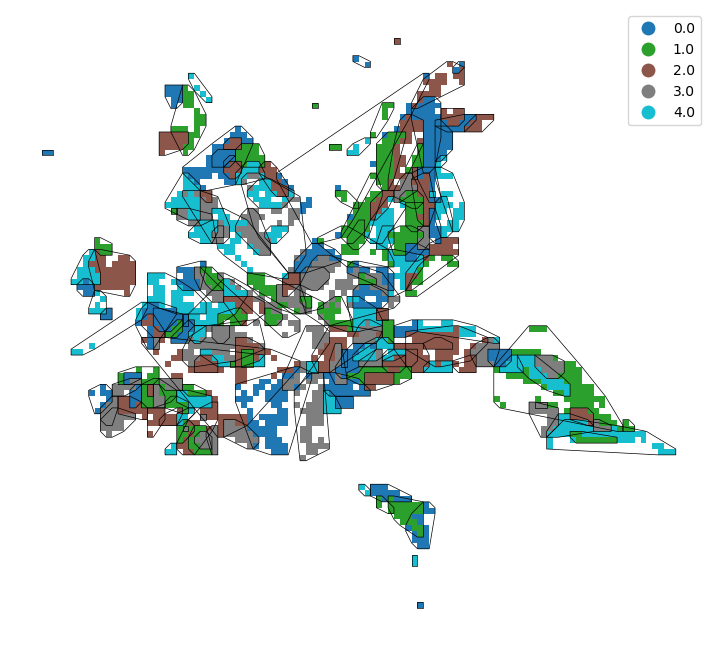

In [35]:
ax = training_sample.plot(
  "split", categorical=True, figsize=(9, 9), markersize=0.1, legend=True
)
training_sample.dissolve("morph_label").convex_hull.boundary.plot(
    ax=ax, color="k", linewidth=0.5, markersize=0
)
ax.set_axis_off()

In [36]:
train = training_sample["split"] != 0
X_train = independent.loc[train]
y_train = training_sample["label"].loc[train]

test = training_sample["split"] == 0
X_test = independent.loc[test]
y_test = training_sample["label"].loc[test]

In [37]:
rf_spatial_cv = ensemble.RandomForestClassifier(random_state=0, n_jobs=-1)
rf_spatial_cv.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=0)

In [38]:
pred = rf_spatial_cv.predict(X_test)

accuracy_spatial_cv = metrics.accuracy_score(pred, y_test)
kappa_spatial_cv = metrics.cohen_kappa_score(pred, y_test)

summary += f"""\
Basic model with spatial cross-validation:
  Accuracy: {round(accuracy_spatial_cv, 3)}
  Kappa:    {round(kappa_spatial_cv, 3)}
"""

print(summary)

Evaluation metrics
Basic model:
  Accuracy: 0.326
  Kappa:    0.246
Basic model with spatial cross-validation:
  Accuracy: 0.305
  Kappa:    0.223



In [39]:
pd.Series(model.feature_importances_, index=model.feature_names_in_).sort_values()

familysize      0.126201
%rented         0.134333
%german         0.137389
apartmentno     0.144028
buildingyear    0.145118
age             0.154334
floorspace      0.158597
dtype: float64

In [40]:
# Create Tree Explainer object that can calculate shap values
explainer = shap.TreeExplainer(rf_spatial_cv)

In [41]:
shap_values = explainer.shap_values(X_test)

SHAP summary plot for class: 3
SHAP summary plot for class: 4
SHAP summary plot for class: 5
SHAP summary plot for class: 6
SHAP summary plot for class: 7
SHAP summary plot for class: 8
SHAP summary plot for class: 9
SHAP summary plot for class: 10
SHAP summary plot for class: 11
SHAP summary plot for class: 12
SHAP summary plot for class: 13
SHAP summary plot for class: 14
SHAP summary plot for class: 15
SHAP summary plot for class: 16


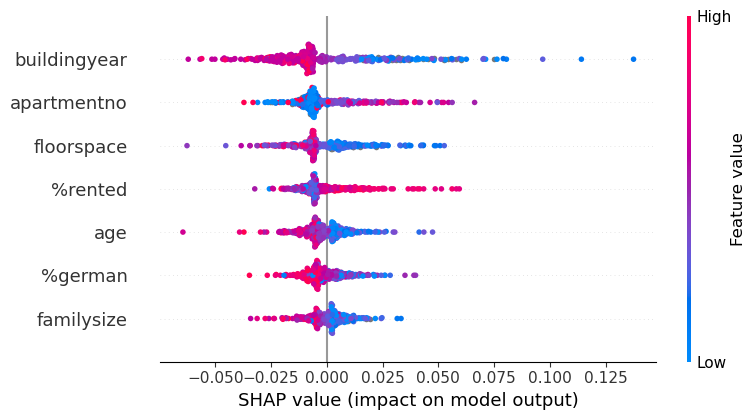

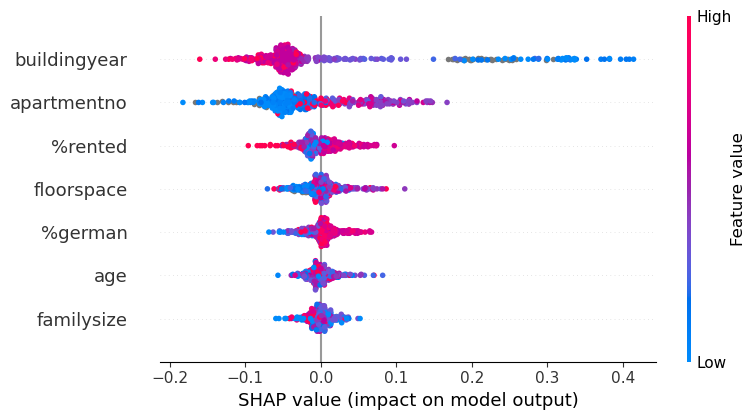

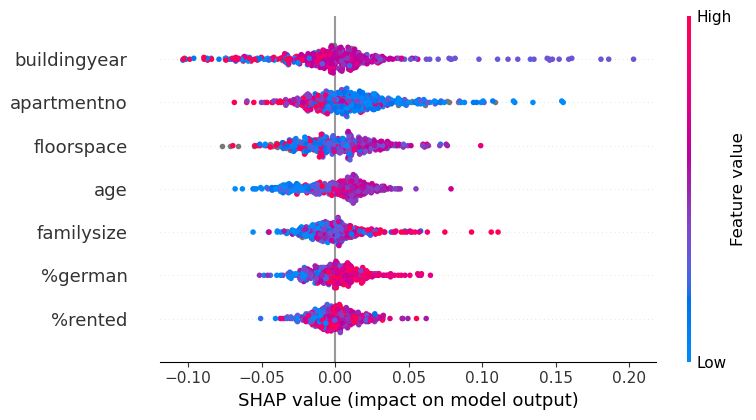

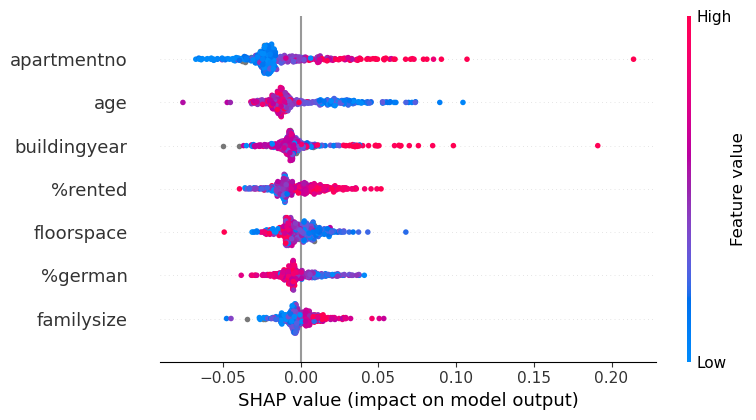

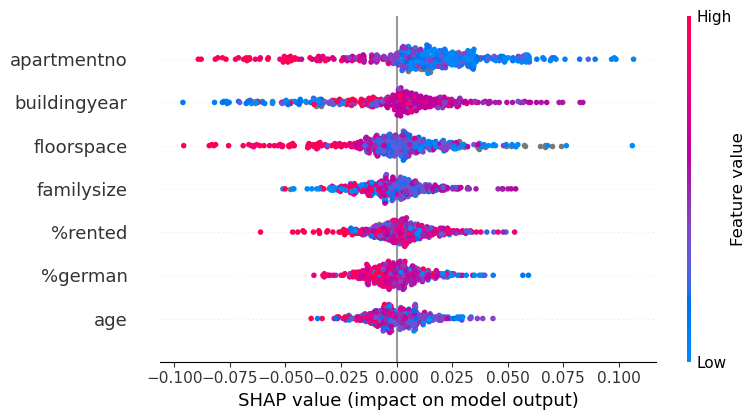

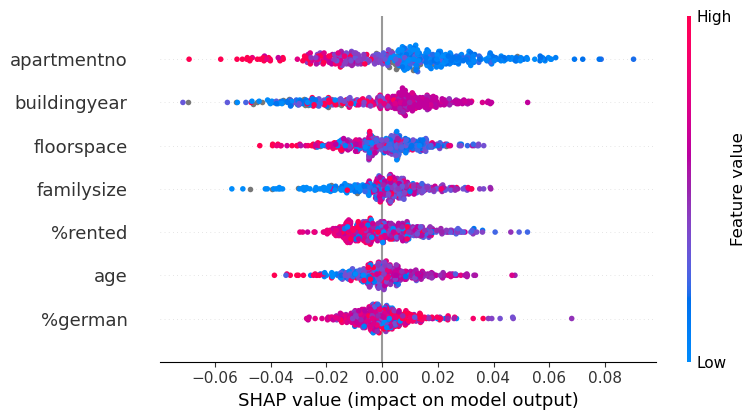

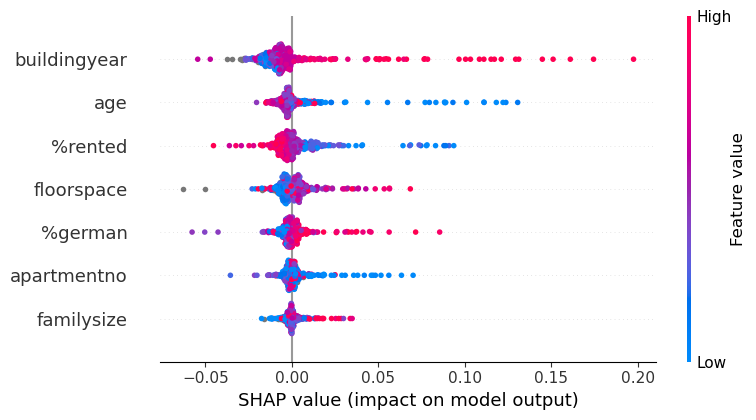

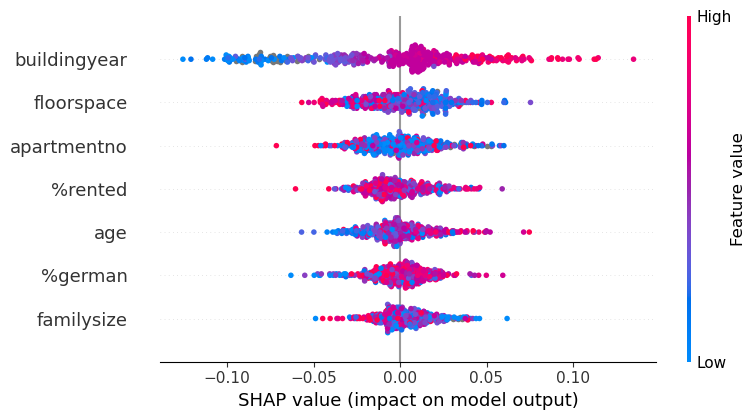

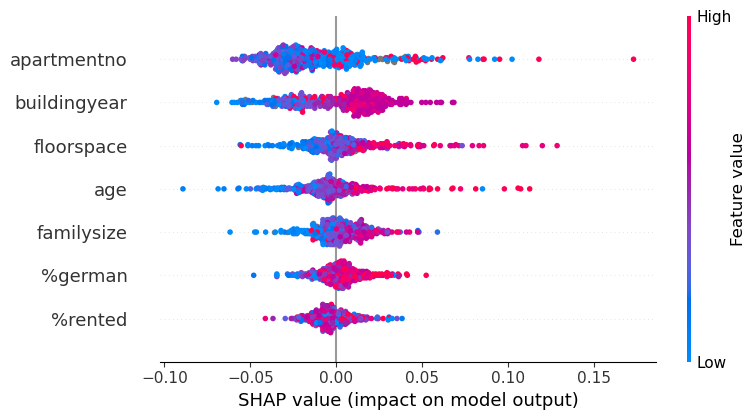

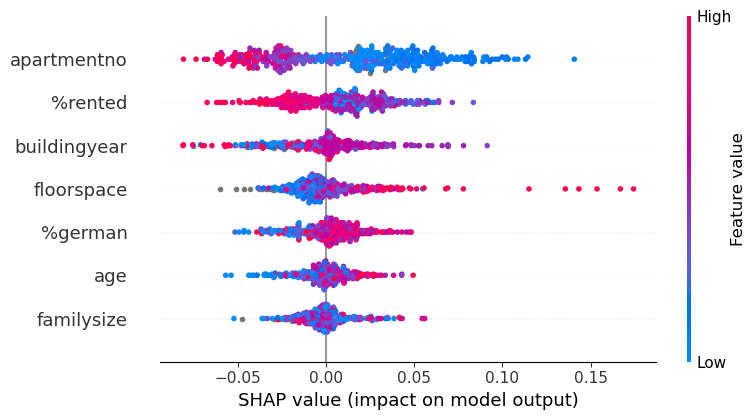

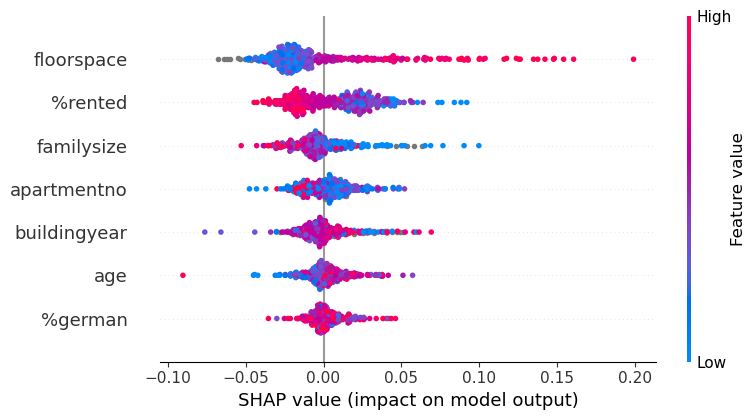

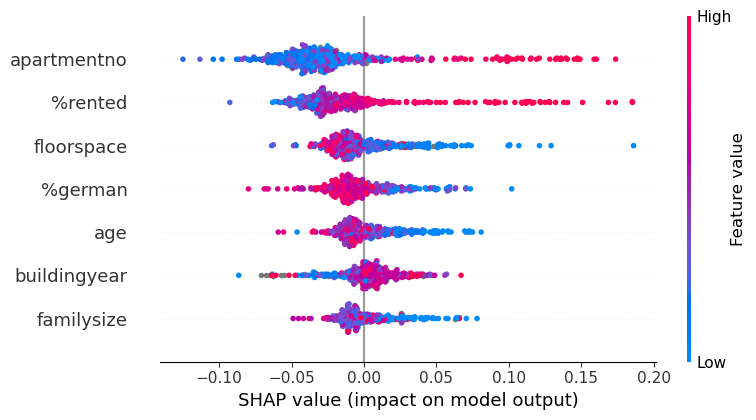

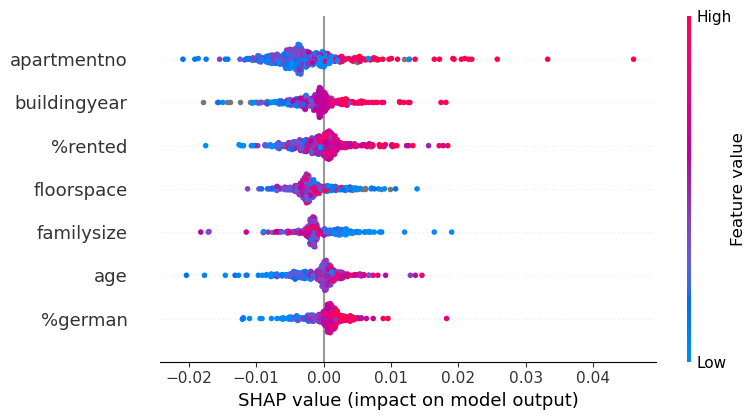

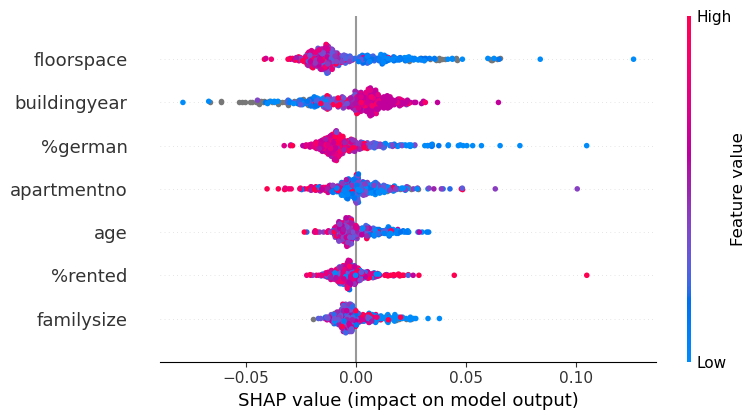

In [50]:
import matplotlib.pyplot as plt
for i, class_name in enumerate(rf_spatial_cv.classes_):
    print(f"SHAP summary plot for class: {class_name}")
    plt.figure()
    shap.summary_plot(shap_values[:,:,i], X_test, feature_names=independent_variables,show=False)
    plt.savefig('shap_cluster'+str(class_name)+'.png')